In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import spatial
import networkx as nx
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix

In [2]:
# load data and get a small preview
DATA_PATH = "lalonde.csv"
df_original = pd.read_csv(DATA_PATH)

df_original.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


# Question 1

### Part 1

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
# get only useful columns
df_part1 = df_original[['treat', 're78']].copy()

# separate the two groups
df_part1_control = df_part1[df_part1.treat == 0].copy()
df_part1_test = df_part1[df_part1.treat == 1].copy()
print("Control size : "+str(df_part1_control.shape[0])+" ; Test size : "+str(df_part1_test.shape[0]))

Control size : 429 ; Test size : 185


We can already see that the sizes of the control and test sets are quite different, which is not very promising.    
Let's try to extract some info by using two graphic representations: an histogram and a box plot.

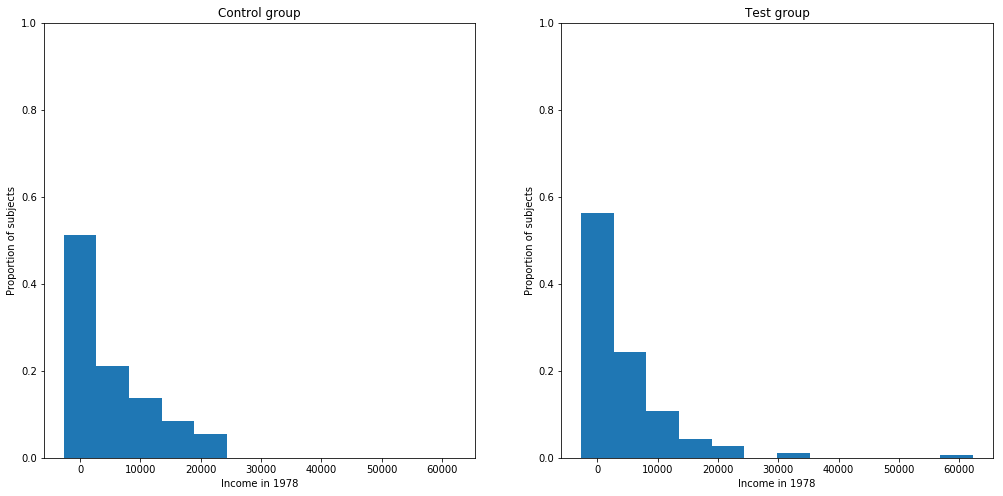

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
def bar_subplot(ax, df, title):
    ax.set_ylim(0, 1)
    results, edges = np.histogram(df, normed=True, bins=np.linspace(0, 65000, 13))
    binWidth = edges[1] - edges[0]
    ax.bar(edges[:-1], results*binWidth, binWidth)
    ax.set_title(title)
    ax.set_xlabel("Income in 1978")
    ax.set_ylabel("Proportion of subjects")
    
#Same scale for both plots
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

# sub plot for control group
bar_subplot(axes[0],df_part1_control.re78, "Control group")

# sub plot for test group
bar_subplot(axes[1],df_part1_test.re78, "Test group")


No really useful insight here. It looks like the test group has some outlier, but otherwise both group looks the same.

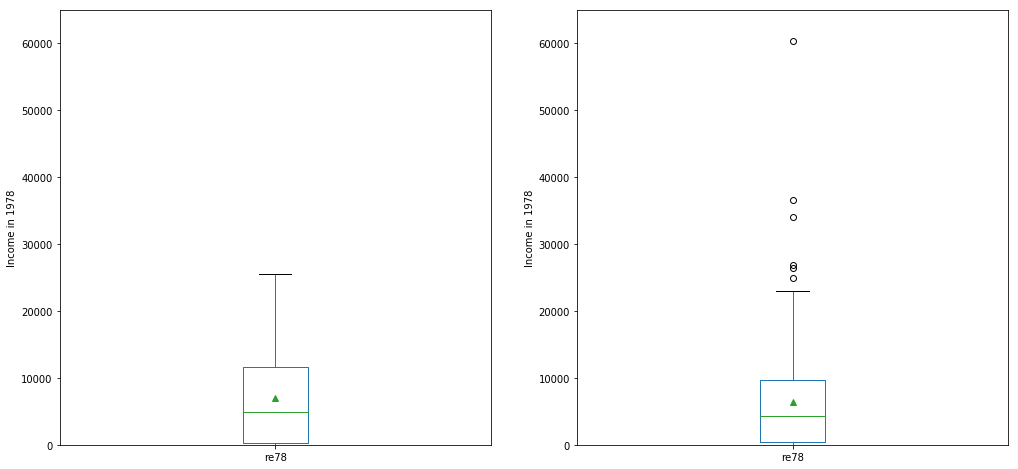

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

def box_subplot(ax, df, title):
    ax.set_ylim(0,65000)
    ax.set_ylabel("Income in 1978")
    df.re78.plot.box(ax=ax,showmeans=True)

box_subplot(axes[0],df_part1_control,"Control group")
box_subplot(axes[1],df_part1_test,"Test group")

Box plots aren't always obvious to analyze. However, we can almost get to the same conclusion than the one for the histogram, few outliers in the test group, but nothing evident at first glance. The median and mean seems to be the same.

We would conclude then that the "treatment" (training) has no effect on the income.

### Part 2

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [6]:
# function that split data in control/test and display both the histogram and box plot
def describeLinearData(data, column_name, separator_column, ylabel, ylim, height = 8):
    data = data.copy()

    data_control = data[data[separator_column] == 0]
    data_test = data[data[separator_column] == 1]

    fix, axes = plt.subplots(2, 2, figsize=(17, height))
    plt.suptitle(column_name)
    
    axes[0, 0].set_title('Box plot of control set')
    axes[0, 1].set_title('Box plot of test set')
    axes[1, 0].set_title('Histogram of control set')
    axes[1, 1].set_title('Histogram of test set')

    data_control[column_name].plot.box(ax=axes[0, 0], showmeans=True)
    data_test[column_name].plot.box(ax=axes[0, 1], showmeans=True)
    
    axes[0, 0].set_ylabel(ylabel)
    axes[0, 1].set_ylabel(ylabel)
    axes[0, 0].set_ylim(0, ylim)
    axes[0, 1].set_ylim(0, ylim)
    axes[1, 0].set_xlabel(ylabel)
    axes[1, 1].set_xlabel(ylabel)
    axes[1, 0].set_ylabel("Proportion of subjects")
    axes[1, 1].set_ylabel("Proportion of subjects")
    axes[1, 0].set_ylim(0, 1)
    axes[1, 1].set_ylim(0, 1)

    results, edges = np.histogram(data_control[column_name], normed=True, bins=np.linspace(0, max(data_control[column_name]), 10))
    binWidth = edges[1] - edges[0]
    axes[1, 0].bar(edges[:-1], results*binWidth, binWidth)

    results, edges = np.histogram(data_test[column_name], normed=True, bins=np.linspace(0, max(data_test[column_name]), 10))
    binWidth = edges[1] - edges[0]
    axes[1, 1].bar(edges[:-1], results*binWidth, binWidth)

# function that allow to print bar plot on a column_name after group_by on a separator_column 
def describeBinaryData(data, column_name, separator_column):
    
    copied_data = data.copy()
    
    groupby_data=copied_data.groupby([copied_data[column_name]])[separator_column]
    ax=groupby_data.value_counts().unstack(column_name).plot(kind='bar', legend=False)
    patches, labels = ax.get_legend_handles_labels()
    ax.set_xlabel("Treated")
    ax.set_ylabel("Number of subjects")
    ax.legend(patches, ['%s 0' % column_name,'%s 1' % column_name], loc='best')

Let's try to get insight on the features this time, instead of the output of the study.
First we will output the continuous features, then the discrete ones.

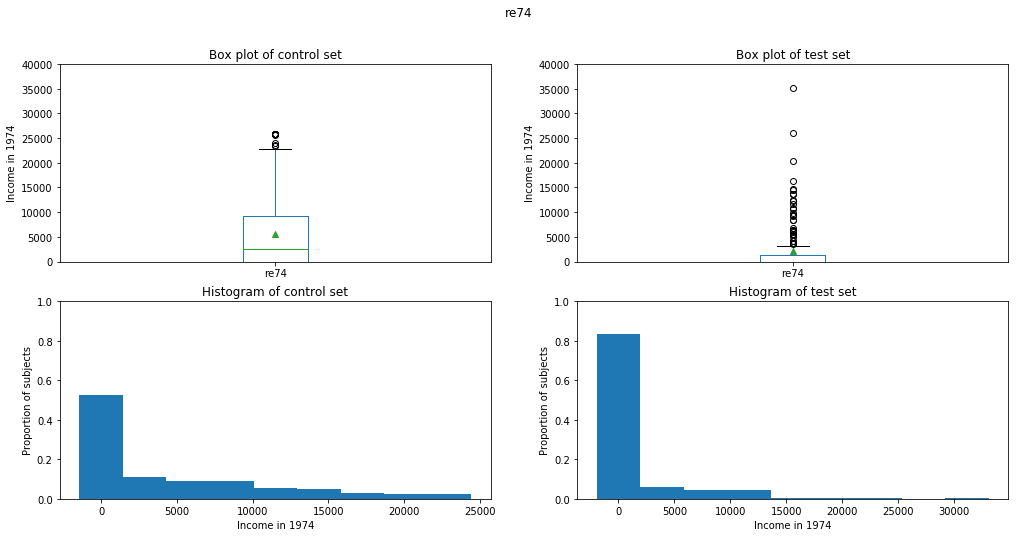

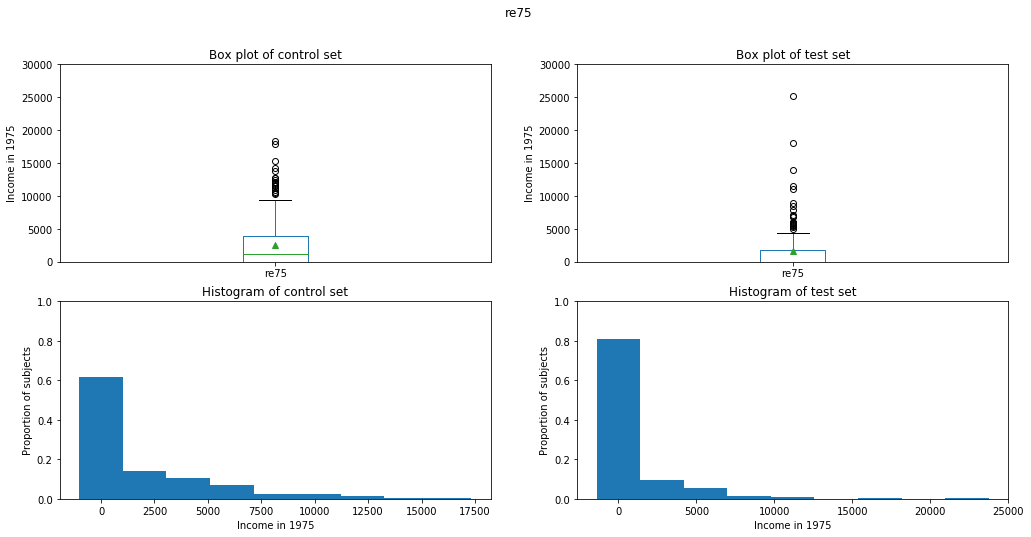

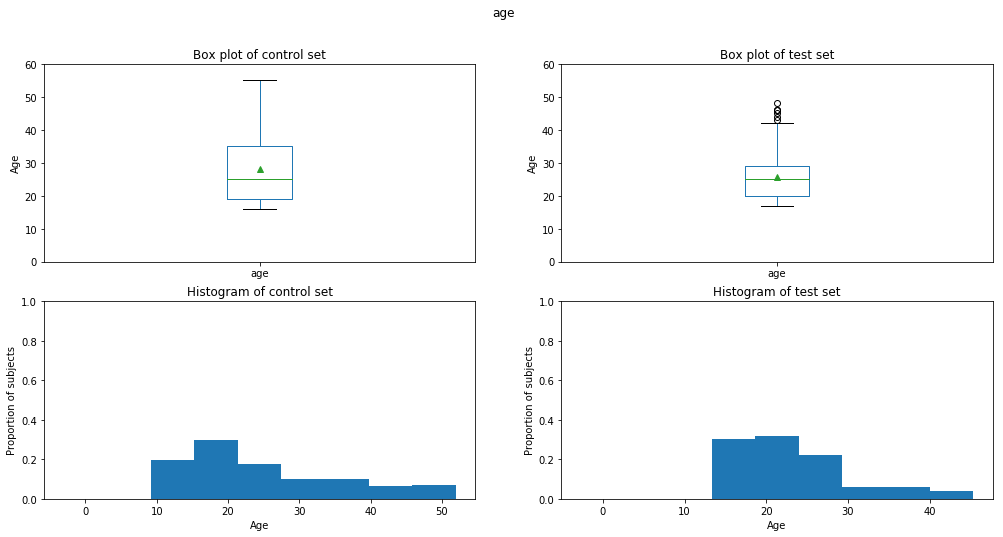

In [7]:
describeLinearData(df_original, 're74', 'treat', 'Income in 1974', 40000)
describeLinearData(df_original, 're75', 'treat', 'Income in 1975', 30000)
describeLinearData(df_original, 'age', 'treat', 'Age', 60)

Again, nothing relevant the continious features.
re74 and re75 are full of 0.0 samples (more than a third of the whole dataset), which lead to the conclusion that most people hadn't a job before the experiment. We could say that for this feature, it looks like both group are represented in the same proportion.
For the age, you could maybe argue that the control group is a bit older than the test one, but nothing alarming again.

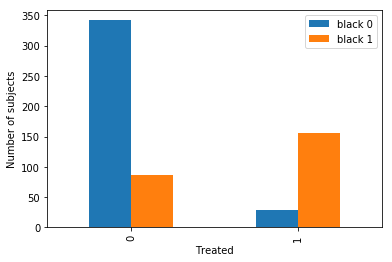

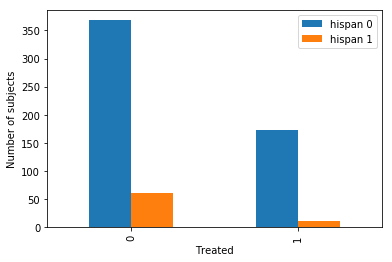

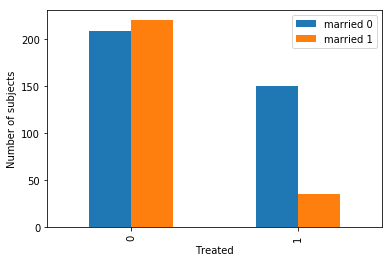

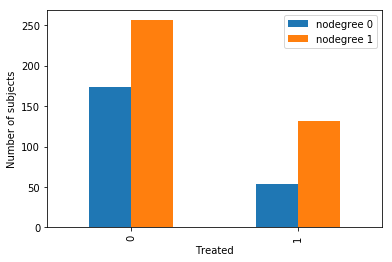

In [8]:
describeBinaryData(df_original, 'black', 'treat')
describeBinaryData(df_original, 'hispan', 'treat')
describeBinaryData(df_original, 'married', 'treat')
describeBinaryData(df_original, 'nodegree', 'treat')

Now we get something interesting. We see a high difference in proportion for the amount of black people represented in both group and for married people too. 
This means that the whole experience is biased.

### Part 3 A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:

from sklearn import linear_model
logistic = linear_model.LogisticRegression()
Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)

So we are going to use a logistic regression model as provided in the tutorial.

If the experiment is well constructed, we should get that each person has a 50/50 chance to get in either group. However, as noticed earlier, the two groups are not of equal size, which is a major problem.

In [9]:
logistic = linear_model.LogisticRegression()

# get only relevant feature for the X matrix
feature_columns = ['black', 'hispan', 'age', 'educ', 'married','nodegree', 're74', 're75']
X = df_original[feature_columns]

# the outcome is either treat or not
Y = df_original.treat

logistic.fit(X, Y)

for f in range(len(feature_columns)):
    print("{0} * {1} + ".format(logistic.coef_[0][f], feature_columns[f]))
print(logistic.intercept_)

2.6807554381952468 * black + 
0.5735450355894234 * hispan + 
-0.0037890704539388746 * age + 
-0.019034833933599254 * educ + 
-0.7743287170966496 * married + 
-0.13970795045734336 * nodegree + 
-7.294873725228013e-05 * re74 + 
5.060387605142e-05 * re75 + 
[-1.47713894]


From the equation representation we can extract some very useful information, like the fact that being black is going to hugely influence the outcome and to a lesser extent (but still important in comparison to other features) the fact that you are married or not, and if you have a degree or not. If you are black, you have a big chance to go in the test group for example.

In [10]:
# predict the outcome for the train dataset
prediction = logistic.predict_proba(X)

# add the result to the original dataframe
df_original['d0'] = np.array(prediction)[:, 0]
df_original['d1'] = np.array(prediction)[:, 1]

# get a preview of the prediction
prediction

array([[ 0.51499524,  0.48500476],
       [ 0.78549397,  0.21450603],
       [ 0.29702054,  0.70297946],
       ..., 
       [ 0.8698164 ,  0.1301836 ],
       [ 0.4817193 ,  0.5182807 ],
       [ 0.86398445,  0.13601555]])

As expected, it seems that depending on your features, you are much more likely to find yourself in a group rather than in the other one.

### Part 4 Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

Like said before, the dataset isn't balanced on the treat feature. It's time to balance it, to see if our remark done in the previous part was correct.

In order to do so, we need to match people from both group together. This done by a bipartite matching algorithm.

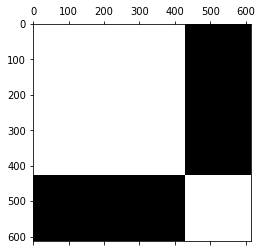

In [11]:
# creation of the bipartite graph structure, a adjacency matrix here
propensity_scores = df_original.sort_values(by='treat')[['d0']]
nb_tested = len(df_part1_test)

# compute the weight of each edge
distances = spatial.distance.squareform(spatial.distance.pdist(propensity_scores.values, 'euclidean'))
kernel_width = distances.mean()
weights = np.exp(-np.square(distances/kernel_width**2))

# put to 0 each unwanted connection, 
# which means for a bipartite graph the nodes treat = 0 together and treat = 1 together
weights[:-nb_tested, :-nb_tested] = 0
weights[-nb_tested:, -nb_tested:] = 0

# check that we have 0 and weights at the right place
plt.spy(weights)

We can see the adjacency matrix above : If the point is black, this means that there exists an edge between the two persons.

In [12]:
# algorithm to find the max weight matching among all possible max matching
result = nx.max_weight_matching(nx.Graph(weights))

In [13]:
# time to get the matched nodes/persons together
idx_matched = propensity_scores.iloc[list(result.keys())].index.values

# be careful, the node number for the bipartite was done on the sorted persons !
matched_samples = df_original.loc[idx_matched]

# add the matched node
matched_samples.loc[idx_matched, 'matched_idx'] = list(result.values())

In [14]:
matched_samples.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,d0,d1,matched_idx
103,NSW104,1,18,11,1,0,0,1,0.0,0.0,4814.627,0.312959,0.687041,154
558,PSID374,0,18,11,1,0,0,1,0.0,0.0,0.000,0.312959,0.687041,578
104,NSW105,1,19,11,1,0,0,1,0.0,0.0,7458.105,0.313774,0.686226,270
572,PSID388,0,19,11,1,0,0,1,0.0,0.0,16485.520,0.313774,0.686226,581
91,NSW92,1,17,10,1,0,0,1,0.0,0.0,0.000,0.308073,0.691927,191


In [15]:
# make sure we have the same amount of people in both group
matched_samples.treat.value_counts()

1    185
0    185
Name: treat, dtype: int64

The matching being done, it's time to display again the graph used in previous part.

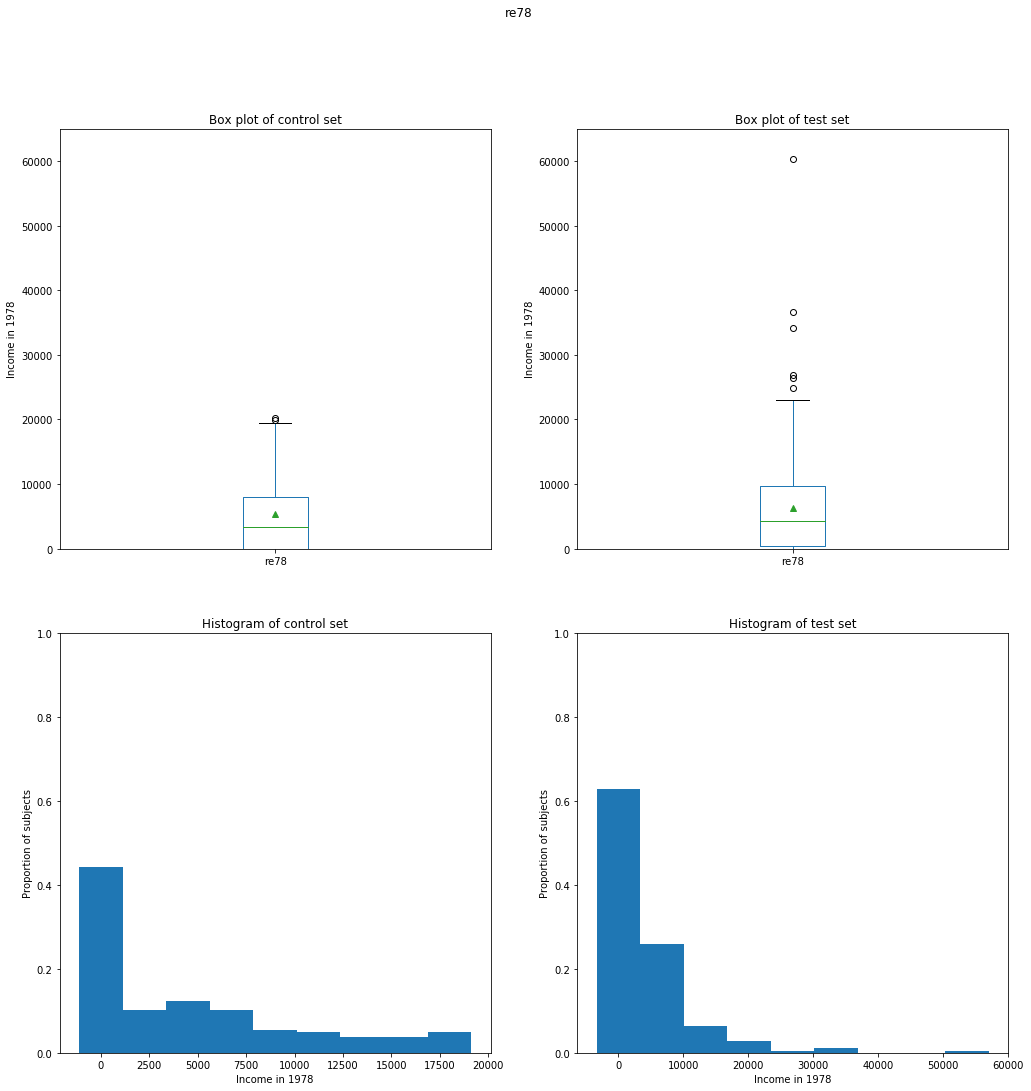

In [16]:
describeLinearData(matched_samples, 're78', 'treat', "Income in 1978",65000, 17)

The outcome doesn't give us anything again, apart from the outliers in the test group, still present obviously.

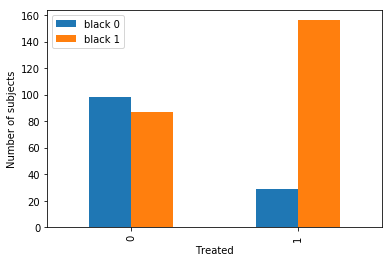

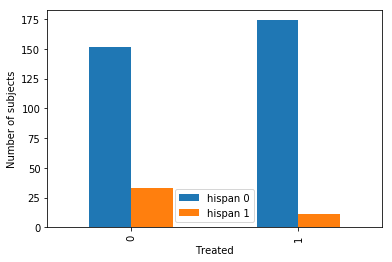

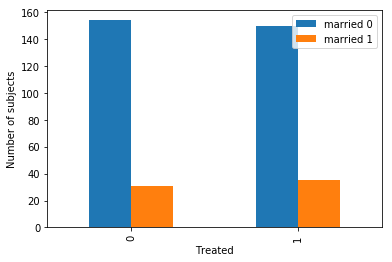

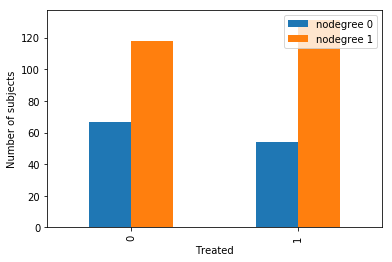

In [17]:
describeBinaryData(matched_samples, 'black', 'treat')
describeBinaryData(matched_samples, 'hispan', 'treat')
describeBinaryData(matched_samples, 'married', 'treat')
describeBinaryData(matched_samples, 'nodegree', 'treat')

Now something really interesting. Both group are now proportional in every feature, except the black one. As we can see, the married is now proportional too, but black are over represented in the test group, which means we need to balance it again.

### Part 5 Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

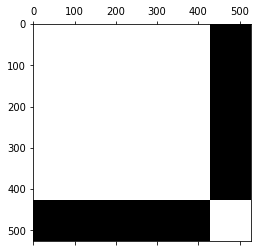

In [18]:
# As said above, we need the same amount of black people in both group before performing
# the bipartite matching algorithm, and obviously we need to take random sample of the biggest group 
new_df = df_original.drop(df_original[(df_original.black == 1) & (df_original.treat == 1)]\
                       .sample(len(df_original[(df_original.black == 1) & (df_original.treat == 0)])).index.values)


# same as part4
propensity_scores = new_df.sort_values(by='treat')[['d0']]
nb_tested = len(new_df[new_df.treat == 1])

distances = spatial.distance.squareform(spatial.distance.pdist(propensity_scores.values, 'euclidean'))
kernel_width = distances.mean()
weights = np.exp(-np.square(distances/kernel_width**2))
weights[:-nb_tested, :-nb_tested] = 0
weights[-nb_tested:, -nb_tested:] = 0
plt.spy(weights)


In [19]:
result = nx.max_weight_matching(nx.Graph(weights))

In [20]:
idx_matched = propensity_scores.iloc[list(result.keys())].index.values
matched_samples = new_df.loc[idx_matched]
matched_samples.loc[idx_matched, 'matched_idx'] = list(result.values())

In [21]:
matched_samples.treat.value_counts()

1    98
0    98
Name: treat, dtype: int64

We can see that we lost almost 100 samples between the balanced black and unbalanced black dataset. 

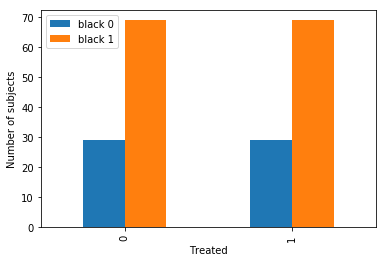

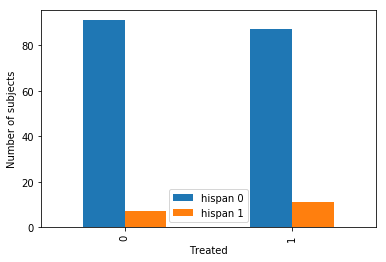

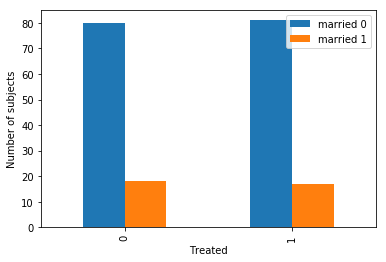

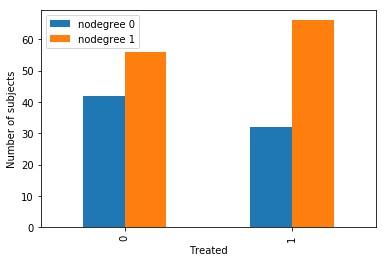

In [22]:
describeBinaryData(matched_samples, 'black', 'treat')
describeBinaryData(matched_samples, 'hispan', 'treat')
describeBinaryData(matched_samples, 'married', 'treat')
describeBinaryData(matched_samples, 'nodegree', 'treat')

Every feature is now reasonably proportional in both group, let's see if the outcome tells us something now.

### Part6  A less naive analysis

Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?



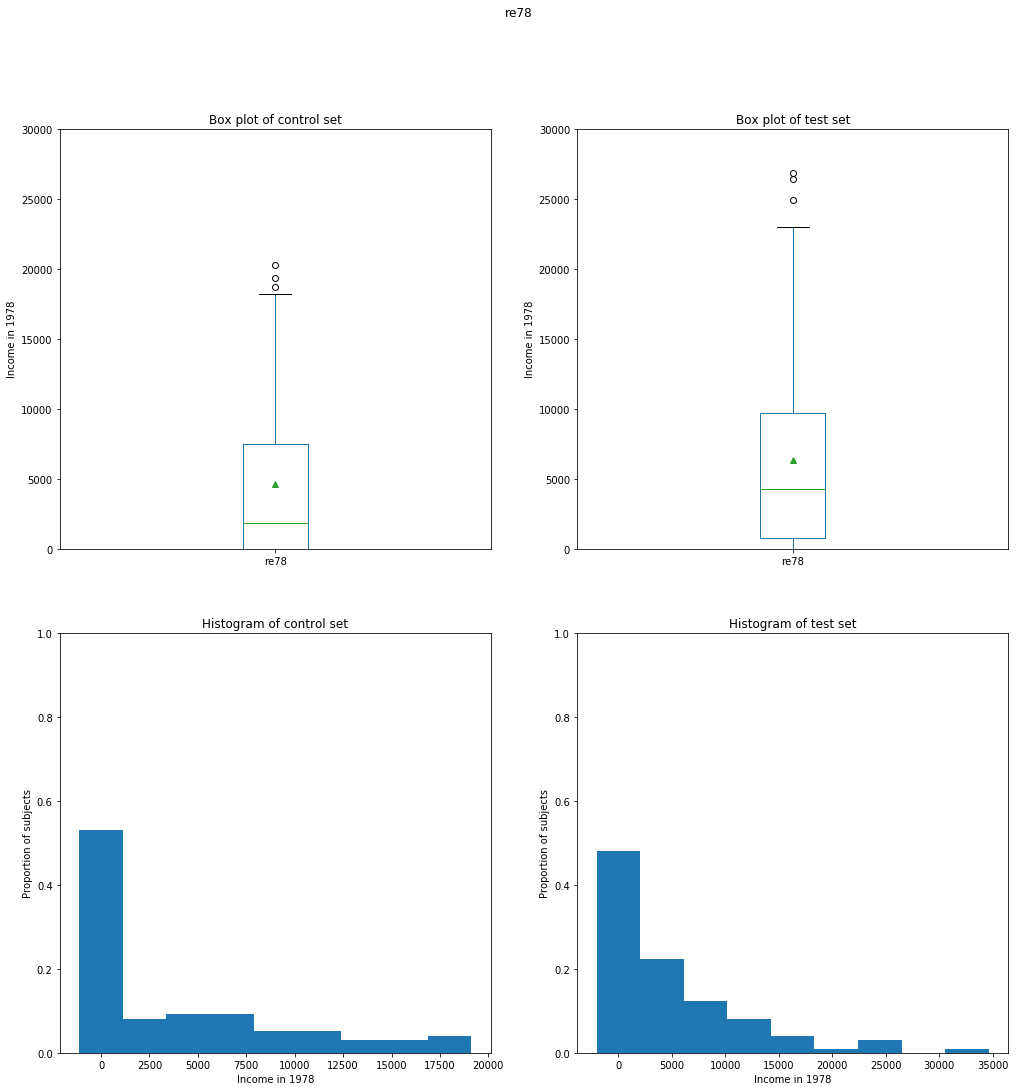

In [23]:
describeLinearData(matched_samples, 're78', 'treat', "Income in 1978", 30000, 17)

Now we can start talking. As displayed in box plot, we can see the median is twice as big for the test group than for the control group. Same thing for the 3rd quartile, which is 2500 higher for the test group.

We can now conclude that the treatment is working!

# Question 2

### Part1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

We simply use fetch_20newsgroups to get the dataset, and then the vectorizer to get the features using 'data' and the labels using 'target'.

In [24]:
newsgroups_train_file = fetch_20newsgroups()

In [25]:
newsgroups_train = newsgroups_train_file.data
newsgroups_labels = newsgroups_train_file.target
len(newsgroups_train)

11314

In [26]:
tfidf = TfidfVectorizer()

In [27]:
features = tfidf.fit_transform(newsgroups_train)

In [28]:
features.shape

(11314, 130107)

In [29]:
from random import shuffle
idx = list(range(features.shape[0]))
shuffle(idx)
print(type(idx))

train = features[idx[:int(features.shape[0]*.8)], :]
train_labels = newsgroups_labels[idx[:int(features.shape[0]*.8)]]

test = features[idx[int(features.shape[0]*.8):int(features.shape[0]*.9)], :]
test_labels = newsgroups_labels[idx[int(features.shape[0]*.8):int(features.shape[0]*.9)]]


validation = features[idx[int(features.shape[0]*.9):], :]
validation_labels = newsgroups_labels[idx[int(features.shape[0]*.9):]]


<class 'list'>


## Part 2
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature importances attribute of your random forest and discuss the obtained results.

In [31]:

#Grid search for n_estimators and max_depth
def grid_search():
    features_sqrt = np.sqrt(train.shape[0]) #=~90
    best_score = 0
    best_classifier = None
    for estimator in np.arange(50,500,50):
        for depth in np.linspace(max(features_sqrt-50,1),features_sqrt+50,10): #Default = features_sqrt
            classifier = RandomForestClassifier(n_jobs=8, n_estimators=estimator, max_depth=depth, verbose=True)
            classifier.fit(train, train_labels)
            score = classifier.score(validation, validation_labels)
            if score>best_score:
                best_classifier=classifier
                best_score = score
    print("Best score : "+str(best_score)+" ; Num estimators : "+str(best_classifier.n_estimators)+" ; Max depth : "+str(best_classifier.max_depth))

best_classifier = RandomForestClassifier(n_jobs=8, n_estimators = 400, max_depth=90) #score = 0.84628975265

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: 

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks    

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   18.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks    

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   31.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   35.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   37.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks    

Best score : 0.84628975265 ; Num estimators : 400 ; Max depth : 89.5811881348


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    0.1s finished


We found the best classifier using a grid search on n_estimators from 50 to 500 by 50, and on max_depth from sqrt(len(features))-50 to sqrt(len(features))+50 by steps of 10. The default max_depth seems to be the best, and the best number of classifiers seems to be 400.

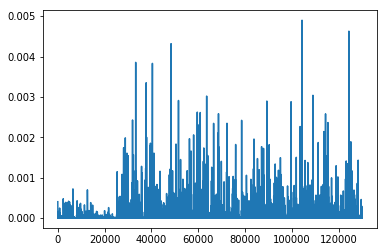

In [32]:
plt.plot(best_classifier.feature_importances_)

Using feature_importances, we can see that some features are very important and some nearly useless, which means that we could remove the useless ones / keep only the important ones and therefore improve our model as well as the speed it is trained (given that there are more than 130000 features, the speedup could be quite considerable).

In [33]:
confusion_mx = pd.DataFrame(confusion_matrix(test_labels, best_classifier.predict(test)))
confusion_mx

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,41,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0,0,0,4
1,0,37,4,1,0,4,2,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0,0,51,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,5,7,41,2,0,7,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,3,1,3,37,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,2,2,0,0,42,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,50,1,0,0,0,0,2,0,0,0,0,1,0,0
7,0,1,0,0,1,1,3,52,1,0,0,0,1,0,1,0,1,0,0,0
8,1,0,0,0,0,0,2,4,55,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,1,0,1,0,0,57,2,0,0,0,0,0,0,0,0,0


We can see that the biggest numbers (by quite a margin) are on the diagonal, which means that the model works quite well. There are still some errors (especially for category 19), but the result is still satisfactory (with a validation accuracy of 0.84628975265).